In [1]:
import os
import parse
import pickle

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.simple_mnist_sigmoid import CFF

%load_ext autoreload
%autoreload 2

In [2]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [3]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/lbfgsm/cff_3-filters_8-kernel_size_50-fc1_sigmoid-activation.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [94]:
def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                row = {'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0], 'sample':adv_samples[s+t]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df)

def create_filtrations(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s,0], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df)


def create_adversary_filtrations(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                # check if this makes sense
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s,0], this_hiddens)
                #
                row = {'filtration':f, 'loss':output.cpu().numpy()[s][0], 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df)

In [5]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/cff_3-filters_8-kernel_size_50-fc1_sigmoid-activation.pt'
model = CFF()
model.load_state_dict(torch.load(model_location))

In [97]:
adv_df = create_adversary_filtrations(model, 50, 1000, adversaries)

torch.Size([6996, 1, 28, 28]) torch.Size([6996])


In [86]:
res_df = create_filtrations(model, 50, 1000)

In [8]:
def create_sample_graphs(df):
    sample_graphs = []
    for s in range(df.shape[0]):
        print(s)
        subgraphs = {}
        f = df['filtration'].iloc[s]
        m = dion.homology_persistence(f)
        dgms = dion.init_diagrams(m,f)
        for i,c in enumerate(m):
            if len(c) == 2:
                if f[c[0].index][0] in subgraphs:
                    subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
                else:
                    eaten = False
                    for k, v in subgraphs.items():
                        if v.has_node(f[c[0].index][0]):
                            v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                            eaten = True
                            break
                    if not eaten:
                        g = nx.Graph()
                        g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        subgraphs[f[c[0].index][0]] = g

        sample_graphs.append(subgraphs)
    return sample_graphs

In [9]:
# adv_sample_graphs = create_sample_graphs(adv_df)
# with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
#     pickle.dump(adv_sample_graphs, f)
# sample_graphs = create_sample_graphs(res_df)
# with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
#     pickle.dump(sample_graphs, f)

sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [10]:
# options = {
#     'node_color': 'red',
#     'node_size': 2,
#     'width': 3,
#     'with_labels':True}
# nx.draw_random(subgraphs[243], **options)

In [98]:
adv_df.head(25)

,class,loss,prediction,sample
0,7,-10.587885,8,0
1,7,-12.125056,9,0
2,2,-4.929872,1,1
3,1,-7.191643,8,2
4,0,-0.893667,9,3
5,4,-7.689786,8,4
6,1,-7.795117,8,5
7,4,-11.512613,8,6
8,9,-8.839874,5,7
9,9,-13.919342,4,7


In [88]:
res_df.head()

,class,loss,prediction
0,7,-7.636029,7
1,2,-9.070738,2
2,1,-4.820397,1
3,0,-0.014299,0
4,4,-13.976552,4


In [95]:
incorrects = res_df[res_df['class'] != res_df['prediction']]
corrects = res_df[res_df['class'] == res_df['prediction']]

In [96]:
incorrects.shape

(131, 3)

In [99]:
correct_list = list(corrects.index)
adv_correct_list = list(adv_df[~np.isin(adv_df['sample'], list(incorrects.index))].index)

In [100]:
sample_graphs = [sample_graphs[i] for i in correct_list]
adv_sample_graphs = [adv_sample_graphs[i] for i in adv_correct_list]

In [101]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']
# COLORS = ['#bfdce7', '#ff6978']

In [102]:
sgl = np.zeros(len(sample_graphs))
for i in range(len(sample_graphs)):
    sgl[i] = len(sample_graphs[i])

adv_sgl = np.zeros(len(adv_sample_graphs))
for i in range(len(adv_sample_graphs)):
    adv_sgl[i] = len(adv_sample_graphs[i])


Text(0.5, 0, 'Number of Generators')

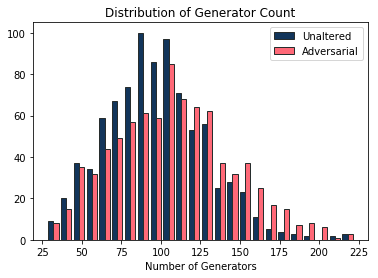

In [103]:
plt.hist([sgl, adv_sgl], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Generator Count')
plt.xlabel('Number of Generators')

In [ ]:
take = 10
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [ ]:
for i in range(len(adv_sample_graphs)):
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [ ]:
edf = pd.DataFrame(np.zeros((len(sample_graphs)+len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] = x[2]['weight']
            
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    for k in list(adv_sample_graphs[i].keys())[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i+len(sample_graphs)][edge_name] = x[2]['weight']

            

In [ ]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(np.concatenate((sgl, adv_sgl), axis=0).reshape(-1,1))
edf['graph counts'] = pd.Series(scaled.T.reshape(-1), index=edf.index)

In [ ]:
edf.tail()

In [ ]:
X = edf.values[:len(sample_graphs)]
y = res_df['class'].values

In [ ]:
clf = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X,y)

In [ ]:
X_adv = edf.values[len(sample_graphs):]
adv_preds = clf.predict(X_adv)

In [ ]:
sklearn.metrics.accuracy_score(adv_df['class'], adv_preds)

In [ ]:
adv_preds[:10]

In [ ]:
adv_df.head(10)

In [ ]:
sklearn.metrics.accuracy_score(adv_df['prediction'], adv_preds)

In [ ]:
clf2 = svm.SVC(gamma='scale', decision_function_shape='ovo').fit(X[:-100],y[:-100])

In [ ]:
sklearn.metrics.accuracy_score(y[-100:], clf2.predict(X[-100:]))

In [104]:
all_gois = []
for i in range(len(sample_graphs)):
    print(i)
    a = [sample_graphs[i][k] for k in sample_graphs[i].keys()]
    all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [105]:
adv_all_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    a = [adv_sample_graphs[i][k] for k in adv_sample_graphs[i].keys()]
    adv_all_gois.append(nx.compose_all(a))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [106]:
eigs = []
for i in range(len(all_gois)):
    print('normal ', i)
    eigs.append(nx.linalg.laplacian_spectrum(all_gois[i]))

adv_eigs = []
for i in range(len(adv_all_gois)):
    print('adv ', i)
    adv_eigs.append(nx.linalg.laplacian_spectrum(adv_all_gois[i]))

normal  0
normal  1
normal  2
normal  3
normal  4
normal  5
normal  6
normal  7
normal  8
normal  9
normal  10
normal  11
normal  12
normal  13
normal  14
normal  15
normal  16
normal  17
normal  18
normal  19
normal  20
normal  21
normal  22
normal  23
normal  24
normal  25
normal  26
normal  27
normal  28
normal  29
normal  30
normal  31
normal  32
normal  33
normal  34
normal  35
normal  36
normal  37
normal  38
normal  39
normal  40
normal  41
normal  42
normal  43
normal  44
normal  45
normal  46
normal  47
normal  48
normal  49
normal  50
normal  51
normal  52
normal  53
normal  54
normal  55
normal  56
normal  57
normal  58
normal  59
normal  60
normal  61
normal  62
normal  63
normal  64
normal  65
normal  66
normal  67
normal  68
normal  69
normal  70
normal  71
normal  72
normal  73
normal  74
normal  75
normal  76
normal  77
normal  78
normal  79
normal  80
normal  81
normal  82
normal  83
normal  84
normal  85
normal  86
normal  87
normal  88
normal  89
normal  90
normal  9

normal  692
normal  693
normal  694
normal  695
normal  696
normal  697
normal  698
normal  699
normal  700
normal  701
normal  702
normal  703
normal  704
normal  705
normal  706
normal  707
normal  708
normal  709
normal  710
normal  711
normal  712
normal  713
normal  714
normal  715
normal  716
normal  717
normal  718
normal  719
normal  720
normal  721
normal  722
normal  723
normal  724
normal  725
normal  726
normal  727
normal  728
normal  729
normal  730
normal  731
normal  732
normal  733
normal  734
normal  735
normal  736
normal  737
normal  738
normal  739
normal  740
normal  741
normal  742
normal  743
normal  744
normal  745
normal  746
normal  747
normal  748
normal  749
normal  750
normal  751
normal  752
normal  753
normal  754
normal  755
normal  756
normal  757
normal  758
normal  759
normal  760
normal  761
normal  762
normal  763
normal  764
normal  765
normal  766
normal  767
normal  768
normal  769
normal  770
normal  771
normal  772
normal  773
normal  774
norm

adv  687
adv  688
adv  689
adv  690
adv  691
adv  692
adv  693
adv  694
adv  695
adv  696
adv  697
adv  698
adv  699
adv  700
adv  701
adv  702
adv  703
adv  704
adv  705
adv  706
adv  707
adv  708
adv  709
adv  710
adv  711
adv  712
adv  713
adv  714
adv  715
adv  716
adv  717
adv  718
adv  719
adv  720
adv  721
adv  722
adv  723
adv  724
adv  725
adv  726
adv  727
adv  728
adv  729
adv  730
adv  731
adv  732
adv  733
adv  734
adv  735
adv  736
adv  737
adv  738
adv  739
adv  740
adv  741
adv  742
adv  743
adv  744
adv  745
adv  746
adv  747
adv  748
adv  749
adv  750
adv  751
adv  752
adv  753
adv  754
adv  755
adv  756
adv  757
adv  758
adv  759
adv  760
adv  761
adv  762
adv  763
adv  764
adv  765
adv  766
adv  767
adv  768
adv  769
adv  770
adv  771
adv  772
adv  773
adv  774
adv  775
adv  776
adv  777
adv  778
adv  779
adv  780
adv  781
adv  782
adv  783
adv  784
adv  785
adv  786
adv  787
adv  788
adv  789
adv  790
adv  791
adv  792
adv  793
adv  794
adv  795
adv  796
adv  797
a

In [107]:
num_top_eigs = 800
top_eigs = np.zeros((len(eigs),num_top_eigs))
for i in range(len(eigs)):
#     top_eigs[i] = np.sort(eigs[i])[::-1][:num_top_eigs] # descending
    top_eigs[i] = np.sort(eigs[i])[:num_top_eigs] # ascending
    
adv_top_eigs = np.zeros((len(adv_eigs),num_top_eigs))
for i in range(len(adv_eigs)):
#     adv_top_eigs[i] = np.sort(adv_eigs[i])[::-1][:num_top_eigs] # descending
    adv_top_eigs[i] = np.sort(adv_eigs[i])[:num_top_eigs] # ascending

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

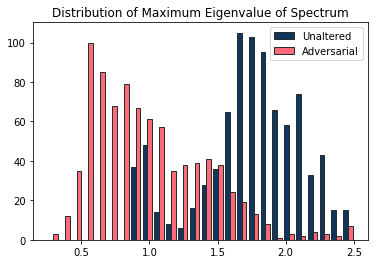

In [108]:
plt.hist([np.amax(top_eigs, axis=1),np.amax(adv_top_eigs, axis=1)], range=[0.25, 2.5], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Mean Eigenvalue of Spectrum')

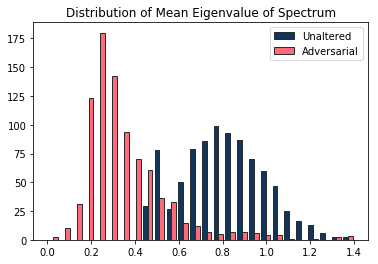

In [109]:
plt.hist([np.mean(top_eigs, axis=1),np.mean(adv_top_eigs, axis=1)], range=[0,1.4], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Mean Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalue of Spectrum')

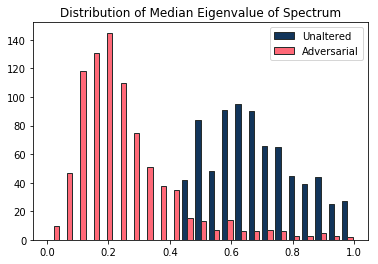

In [110]:
plt.hist([np.median(top_eigs, axis=1),np.median(adv_top_eigs, axis=1)], range=[0,1], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Median Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

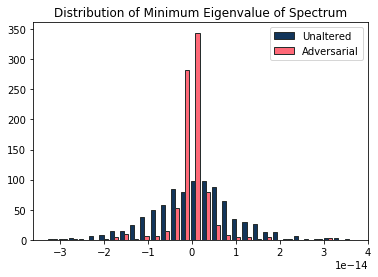

In [111]:
plt.hist([np.amin(top_eigs, axis=1),np.amin(adv_top_eigs, axis=1)], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0, 0.5, 'Probability')

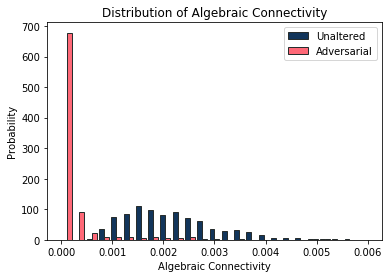

In [112]:
plt.hist([top_eigs[:,1], adv_top_eigs[:,1]], range=[0,0.006], bins='auto',color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Algebraic Connectivity')
plt.xlabel('Algebraic Connectivity')
plt.ylabel('Probability')

In [138]:
mean_eigs = np.zeros((len(eigs),4))
for i in range(len(eigs)):
    mean_eigs[i] = [eigs[i].mean(), eigs[i].shape[0], np.median(eigs[i]), eigs[i][1]]
    
adv_mean_eigs = np.zeros((len(adv_eigs),4))
for i in range(len(adv_eigs)):
    adv_mean_eigs[i] = [adv_eigs[i].mean(), adv_eigs[i].shape[0], np.median(adv_eigs[i]), adv_eigs[i][1]]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

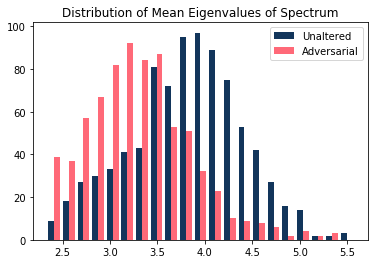

In [114]:
plt.hist([mean_eigs[:,0], adv_mean_eigs[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

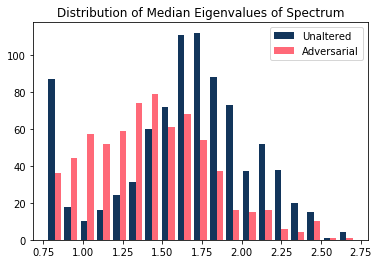

In [115]:
plt.hist([mean_eigs[:,2], adv_mean_eigs[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Algebraic Connectivity')

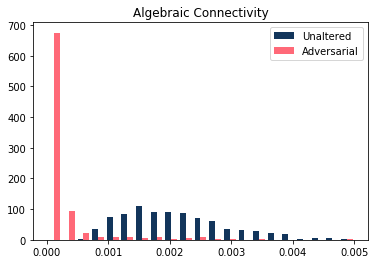

In [140]:
plt.hist([mean_eigs[:,3], adv_mean_eigs[:,3]], range=[0,.005], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Algebraic Connectivity')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

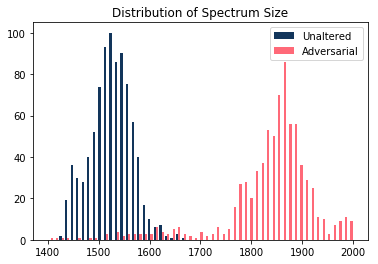

In [116]:
plt.hist([mean_eigs[:,1], adv_mean_eigs[:,1]], range=[1400,2000], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Spectrum Size')

In [117]:
some_num = 10
some_gois = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    some_gois.append(nx.compose_all(a))
    
adv_some_gois = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[len(sgik)-some_num:]]
    adv_some_gois.append(nx.compose_all(a))
    
some_eigs = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs.append(nx.linalg.laplacian_spectrum(some_gois[i]))

adv_some_eigs = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs.append(nx.linalg.laplacian_spectrum(adv_some_gois[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

normal  168
normal  169
normal  170
normal  171
normal  172
normal  173
normal  174
normal  175
normal  176
normal  177
normal  178
normal  179
normal  180
normal  181
normal  182
normal  183
normal  184
normal  185
normal  186
normal  187
normal  188
normal  189
normal  190
normal  191
normal  192
normal  193
normal  194
normal  195
normal  196
normal  197
normal  198
normal  199
normal  200
normal  201
normal  202
normal  203
normal  204
normal  205
normal  206
normal  207
normal  208
normal  209
normal  210
normal  211
normal  212
normal  213
normal  214
normal  215
normal  216
normal  217
normal  218
normal  219
normal  220
normal  221
normal  222
normal  223
normal  224
normal  225
normal  226
normal  227
normal  228
normal  229
normal  230
normal  231
normal  232
normal  233
normal  234
normal  235
normal  236
normal  237
normal  238
normal  239
normal  240
normal  241
normal  242
normal  243
normal  244
normal  245
normal  246
normal  247
normal  248
normal  249
normal  250
norm

adv  6
adv  7
adv  8
adv  9
adv  10
adv  11
adv  12
adv  13
adv  14
adv  15
adv  16
adv  17
adv  18
adv  19
adv  20
adv  21
adv  22
adv  23
adv  24
adv  25
adv  26
adv  27
adv  28
adv  29
adv  30
adv  31
adv  32
adv  33
adv  34
adv  35
adv  36
adv  37
adv  38
adv  39
adv  40
adv  41
adv  42
adv  43
adv  44
adv  45
adv  46
adv  47
adv  48
adv  49
adv  50
adv  51
adv  52
adv  53
adv  54
adv  55
adv  56
adv  57
adv  58
adv  59
adv  60
adv  61
adv  62
adv  63
adv  64
adv  65
adv  66
adv  67
adv  68
adv  69
adv  70
adv  71
adv  72
adv  73
adv  74
adv  75
adv  76
adv  77
adv  78
adv  79
adv  80
adv  81
adv  82
adv  83
adv  84
adv  85
adv  86
adv  87
adv  88
adv  89
adv  90
adv  91
adv  92
adv  93
adv  94
adv  95
adv  96
adv  97
adv  98
adv  99
adv  100
adv  101
adv  102
adv  103
adv  104
adv  105
adv  106
adv  107
adv  108
adv  109
adv  110
adv  111
adv  112
adv  113
adv  114
adv  115
adv  116
adv  117
adv  118
adv  119
adv  120
adv  121
adv  122
adv  123
adv  124
adv  125
adv  126
adv  127


In [118]:
some_mean_eigs = np.zeros((len(some_eigs),5))
for i in range(len(some_eigs)):
    some_mean_eigs[i] = [some_eigs[i].mean(), some_eigs[i].shape[0], np.median(some_eigs[i]), some_eigs[i].min(), some_eigs[i].max()]
    
adv_some_mean_eigs = np.zeros((len(adv_some_eigs),5))
for i in range(len(adv_some_eigs)):
    adv_some_mean_eigs[i] = [adv_some_eigs[i].mean(), adv_some_eigs[i].shape[0], np.median(adv_some_eigs[i]), adv_some_eigs[i].min(), adv_some_eigs[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

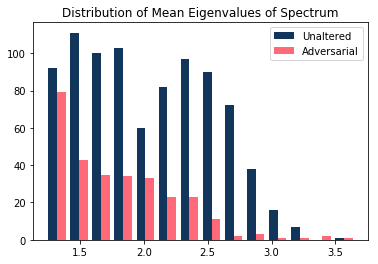

In [119]:
plt.hist([some_mean_eigs[:,0], adv_some_mean_eigs[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

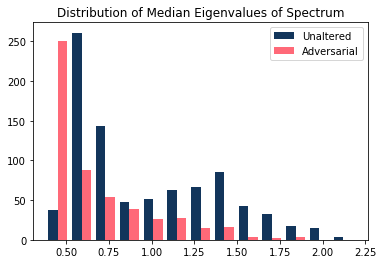

In [120]:
plt.hist([some_mean_eigs[:,2], adv_some_mean_eigs[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

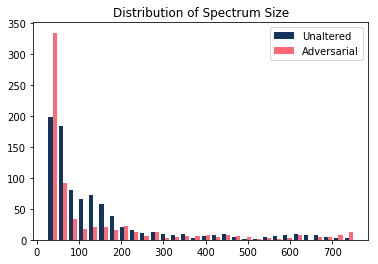

In [121]:
plt.hist([some_mean_eigs[:,1], adv_some_mean_eigs[:,1]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

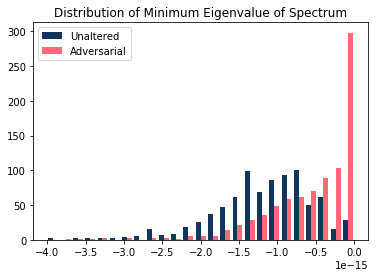

In [122]:
plt.hist([some_mean_eigs[:,3], adv_some_mean_eigs[:,3]], range=[-.4e-14,0], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

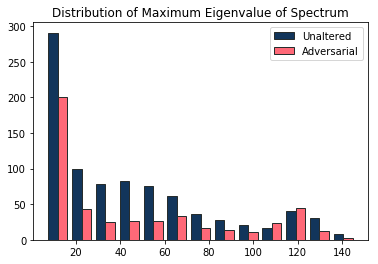

In [123]:
plt.hist([some_mean_eigs[:,4], adv_some_mean_eigs[:,4]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

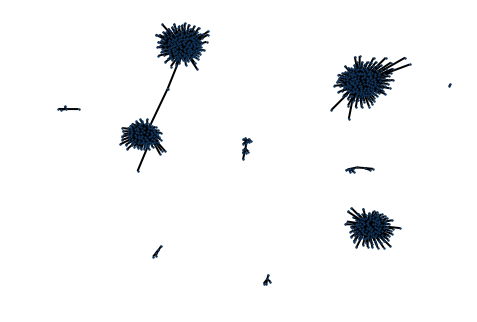

In [124]:
options = {
    'node_color': COLORS[0],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois[2], **options)

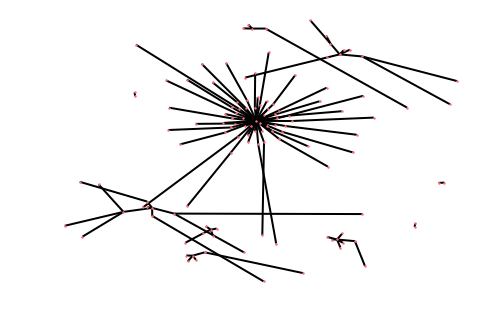

In [125]:
options = {
    'node_color': COLORS[1],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois[2], **options)

In [126]:
some_num = 10
some_gois2 = []
for i in range(len(sample_graphs)):
    print(i)
    sgik = list(sample_graphs[i].keys())
    a = [sample_graphs[i][k] for k in sgik[:some_num]]
    some_gois2.append(nx.compose_all(a))
    
adv_some_gois2 = []
for i in range(len(adv_sample_graphs)):
    print(i)
    sgik = list(adv_sample_graphs[i].keys())
    a = [adv_sample_graphs[i][k] for k in sgik[:some_num]]
    adv_some_gois2.append(nx.compose_all(a))
    
some_eigs2 = []
for i in range(len(some_gois)):
    print('normal ', i)
    some_eigs2.append(nx.linalg.laplacian_spectrum(some_gois2[i]))

adv_some_eigs2 = []
for i in range(len(adv_some_gois)):
    print('adv ', i)
    adv_some_eigs2.append(nx.linalg.laplacian_spectrum(adv_some_gois2[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

normal  153
normal  154
normal  155
normal  156
normal  157
normal  158
normal  159
normal  160
normal  161
normal  162
normal  163
normal  164
normal  165
normal  166
normal  167
normal  168
normal  169
normal  170
normal  171
normal  172
normal  173
normal  174
normal  175
normal  176
normal  177
normal  178
normal  179
normal  180
normal  181
normal  182
normal  183
normal  184
normal  185
normal  186
normal  187
normal  188
normal  189
normal  190
normal  191
normal  192
normal  193
normal  194
normal  195
normal  196
normal  197
normal  198
normal  199
normal  200
normal  201
normal  202
normal  203
normal  204
normal  205
normal  206
normal  207
normal  208
normal  209
normal  210
normal  211
normal  212
normal  213
normal  214
normal  215
normal  216
normal  217
normal  218
normal  219
normal  220
normal  221
normal  222
normal  223
normal  224
normal  225
normal  226
normal  227
normal  228
normal  229
normal  230
normal  231
normal  232
normal  233
normal  234
normal  235
norm

normal  854
normal  855
normal  856
normal  857
normal  858
normal  859
normal  860
normal  861
normal  862
normal  863
normal  864
normal  865
normal  866
normal  867
normal  868
adv  0
adv  1
adv  2
adv  3
adv  4
adv  5
adv  6
adv  7
adv  8
adv  9
adv  10
adv  11
adv  12
adv  13
adv  14
adv  15
adv  16
adv  17
adv  18
adv  19
adv  20
adv  21
adv  22
adv  23
adv  24
adv  25
adv  26
adv  27
adv  28
adv  29
adv  30
adv  31
adv  32
adv  33
adv  34
adv  35
adv  36
adv  37
adv  38
adv  39
adv  40
adv  41
adv  42
adv  43
adv  44
adv  45
adv  46
adv  47
adv  48
adv  49
adv  50
adv  51
adv  52
adv  53
adv  54
adv  55
adv  56
adv  57
adv  58
adv  59
adv  60
adv  61
adv  62
adv  63
adv  64
adv  65
adv  66
adv  67
adv  68
adv  69
adv  70
adv  71
adv  72
adv  73
adv  74
adv  75
adv  76
adv  77
adv  78
adv  79
adv  80
adv  81
adv  82
adv  83
adv  84
adv  85
adv  86
adv  87
adv  88
adv  89
adv  90
adv  91
adv  92
adv  93
adv  94
adv  95
adv  96
adv  97
adv  98
adv  99
adv  100
adv  101
adv  102
adv

In [127]:
some_mean_eigs2 = np.zeros((len(some_eigs2),5))
for i in range(len(some_eigs)):
    some_mean_eigs2[i] = [some_eigs2[i].mean(), some_eigs2[i].shape[0], np.median(some_eigs2[i]), some_eigs2[i].min(), some_eigs2[i].max()]
    
adv_some_mean_eigs2 = np.zeros((len(adv_some_eigs2),5))
for i in range(len(adv_some_eigs2)):
    adv_some_mean_eigs2[i] = [adv_some_eigs2[i].mean(), adv_some_eigs2[i].shape[0], np.median(adv_some_eigs2[i]), adv_some_eigs2[i].min(), adv_some_eigs2[i].max()]

Text(0.5, 1.0, 'Distribution of Mean Eigenvalues of Spectrum')

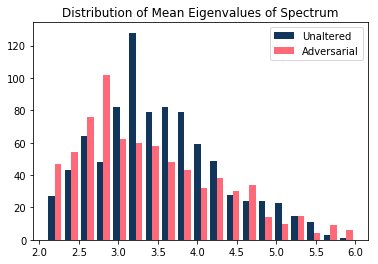

In [128]:
plt.hist([some_mean_eigs2[:,0], adv_some_mean_eigs2[:,0]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Mean Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Median Eigenvalues of Spectrum')

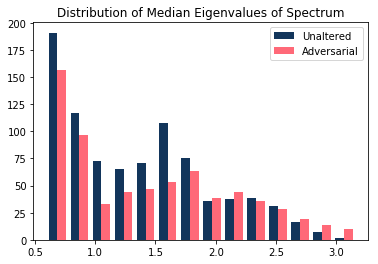

In [129]:
plt.hist([some_mean_eigs2[:,2], adv_some_mean_eigs2[:,2]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Median Eigenvalues of Spectrum')

Text(0.5, 1.0, 'Distribution of Spectrum Size')

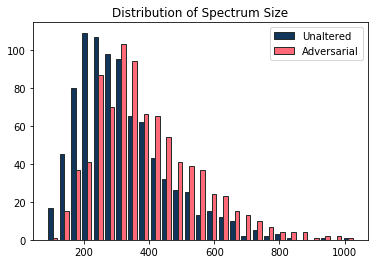

In [130]:
plt.hist([some_mean_eigs2[:,1], adv_some_mean_eigs2[:,1]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Spectrum Size')

Text(0.5, 1.0, 'Distribution of Minimum Eigenvalue of Spectrum')

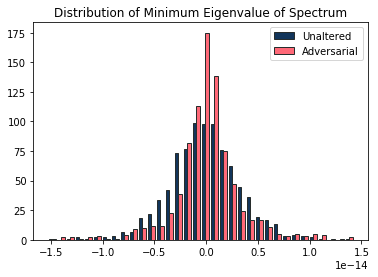

In [131]:
plt.hist([some_mean_eigs2[:,3], adv_some_mean_eigs2[:,3]], bins='auto', color=COLORS, label=PLT_LABELS, edgecolor=EDGE_COLOR)
plt.legend()
plt.title('Distribution of Minimum Eigenvalue of Spectrum')

Text(0.5, 1.0, 'Distribution of Maximum Eigenvalue of Spectrum')

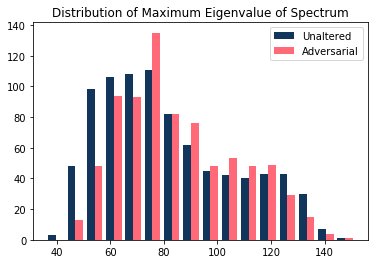

In [132]:
plt.hist([some_mean_eigs2[:,4], adv_some_mean_eigs2[:,4]], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Maximum Eigenvalue of Spectrum')

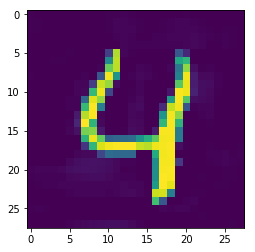

In [133]:
plt.imshow(adversaries[5]['adversary'].reshape(28,28))

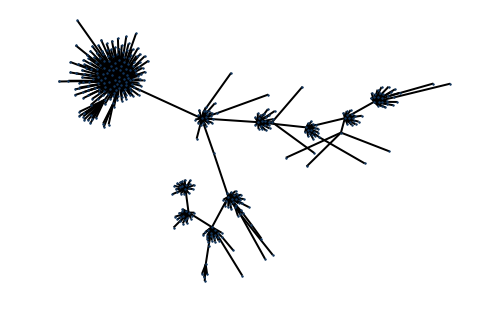

In [134]:
options = {
    'node_color': COLORS[0],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(some_gois2[2], **options)

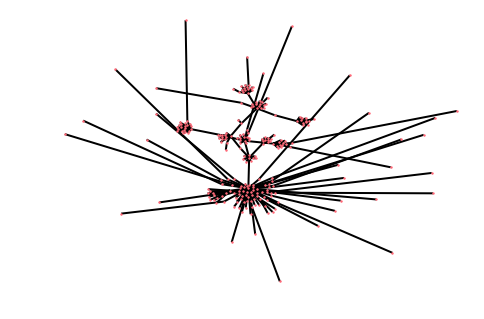

In [135]:
options = {
    'node_color': COLORS[1],
    'node_size': 2,
    'width': 2,
    'with_labels':False}
nx.draw_spring(adv_some_gois2[2], **options)

In [146]:
density = np.zeros(len(all_gois))
adv_density = np.zeros(len(adv_all_gois))
for i in range(len(all_gois)):
    density[i] = nx.classes.function.density(all_gois[i])
for i in range(len(adv_all_gois)):
    adv_density[i] = nx.classes.function.density(adv_all_gois[i])

In [ ]:
plt.hist([density, adv_density], range=[0.008, 0.014], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Distribution of Graph Density')

In [ ]:
weiners = np.zeros(len(all_gois))
for i in range(len(all_gois)):
    print('normal ', i)
    weiners[i] = nx.algorithms.wiener.wiener_index(all_gois[i], weight='weight')

adv_weiners = np.zeros(len(adv_all_gois))
for i in range(len(adv_all_gois)):
    print('adv ', i)
    adv_weiners[i] = nx.algorithms.wiener.wiener_index(adv_all_gois[i], weight='weight')

In [ ]:
plt.hist([weiners, adv_weiners], bins='auto')

In [ ]:
print(res_df['loss'].max())
res_df.iloc[np.where(weiners == .weiners.max())]

In [ ]:
gk = GraphKernel(kernel={"name": "multiscale_laplacian",
                             "which": "fast",
                             "L": 1,
                             "P": 10,
                             "N": 10})
# gk = grakel.RandomWalkLabeled(method_type='fast', verbose=False)

In [ ]:
for i in range(len(all_gois)):
    l = list(all_gois[i].nodes())
    for j in range(len(l)):
        all_gois[i].node[l[j]]['label'] = l[j]

In [ ]:
for i in range(len(adv_all_gois)):
    l = list(adv_all_gois[i].nodes())
    for j in range(len(l)):
        adv_all_gois[i].node[l[j]]['label'] = l[j]

In [ ]:
G_adv = grakel.graph_from_networkx(adv_all_gois, node_labels_tag='label', edge_weight_tag='weight')
G = grakel.graph_from_networkx(all_gois, node_labels_tag='label', edge_weight_tag='weight')

In [ ]:
K_train = gk.fit_transform(G)